### Optimize LSTM model using Genetic algorithm

- For most modern machine learning algorithms, their performance largely depends on hyper-parameters. To fully exploit the capacity of models, we need to fine-tune hyper-parameters for each model.

- However, training machine learning models, like neural networks is a sophisticated process due to the fragility and complexity of the model. We need to search for a set of hyper-parameters for the model that yields the best performance. Each parameter ranges across a wide spectrum of values. Therefore, there are too many configurations. An optimization method should be implemented to search for optimal parameters without spending vast amounts of time.

- In this project, we try to find an optimal set of parameters for the LSTM model to predict airplane passengers in the future.

LSTM code Reference: https://github.com/Ferdib-Al-Islam/lstm-time-series-prediction-pytorch

### Fine-tunning

Here, we select three commonly used hyperparameters as the gene of the genetic algorithm.

(1) Batch size: batch size can affect final results to a certain extent. Because we use the mini-batch gradient descent method to train our model, the size of batch size decides how many samples we randomly select from the dataset.

- If the batch size is small, then the randomness in it will make the training unstable.

- If the batch size is large, then the noise in it will jeopardize the backpropagation process yielding sub-optimal results.

(2) Learning rate: learning rate is the most important hyperparameter for training a neural network. A smaller learning rate will slow the training process, while a larger learning rate will destabilize the training process. Larger learning rates can cause gradient explosion due to the high variance introduced into backpropagation.

(3) Optimizer: in this project, we compare three commonly used optimizers. The usage of different optimizers does not have solid theoretical guidance. Therefore, we will empirically select an optimizer.

#### Download Dataset

In [ ]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv

--2022-06-14 16:08:26--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2180 (2.1K) [text/plain]
Saving to: ‘airline-passengers.csv’

airline-passengers. 100%[===================>]   2.13K  --.-KB/s    in 0s      

2022-06-14 16:08:26 (42.6 MB/s) - ‘airline-passengers.csv’ saved [2180/2180]



#### Import Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import copy
import itertools
from typing import List, Tuple, Dict

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.functional import Tensor

from sklearn.preprocessing import MinMaxScaler

#### Dataset visulization

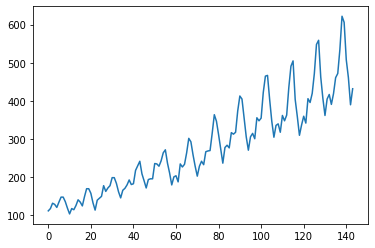

In [ ]:
dataset = pd.read_csv('airline-passengers.csv')
dataset = dataset.iloc[:,1:2].values

plt.plot(dataset, label = 'Airline Passengers Data')
plt.show()

#### Set Fixed Hyper-parameters

In [ ]:
# Dataset settings
val_ratio = 0.8
seq_length = 4

# Model settings
num_epochs = 1001

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
device = 'cuda'

#### Data Loading

In [ ]:
# Define sliding window function
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data) - seq_length - 1):
        _x = data[i: (i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)

In [ ]:
# Data normalization
sc = MinMaxScaler()
dataset_transformed = sc.fit_transform(dataset)

# Data slice generation
x, y = sliding_windows(dataset_transformed, seq_length)

data_x = torch.Tensor(np.array(x))
data_y = torch.Tensor(np.array(y))

# # Data division
# train_size = int(len(y) * val_ratio)
# test_size = len(y) - train_size

# train_x = torch.Tensor(np.array(x[0: train_size]))
# train_y = torch.Tensor(np.array(y[0: train_size]))

# test_x = torch.Tensor(np.array(x[train_size: len(x)]))
# test_y = torch.Tensor(np.array(y[train_size: len(y)]))

In [ ]:
# Define dataset class
class AirplanePassengers(Dataset):
    def __init__(self, data, label):
      self.data = data
      self.label = label
    
    def __getitem__(self, index):
      return self.data[index], self.label[index]

    def __len__(self):
        return self.data.shape[0]

def get_dataset(x: Tensor, y: Tensor):
    return AirplanePassengers(x, y)

def get_dataloader(dataset: Dataset, batch_size: int, mode: str):
    shuffle = True if mode == 'train' else False
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    return dataloader

In [ ]:
# Load dataset
dataset = get_dataset(data_x, data_y)

train_size = int(len(data_y) * val_ratio)
test_size = len(data_y) - train_size
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])

# Build dataloader
def build_dataloader(train_set: Dataset, test_set: Dataset, batch_size: int):
    train_loader = get_dataloader(train_set, batch_size, 'train')
    test_loader = get_dataloader(test_set, batch_size, 'test')
    return train_loader, test_loader

#### Build LSTM Model

In [ ]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)

        out = self.fc(h_out)
        
        return out

#### Training Process

In [ ]:
def train(input_size,
          hidden_size,
          num_layers,
          num_classes,
          device,
          num_epochs,
          train_loader,
          learning_rate,
          optimizer):
    model = LSTM(num_classes, input_size, hidden_size, num_layers).to(device)

    # Mean-squared error for regression
    criterion = torch.nn.MSELoss()
        
    if optimizer == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer == 'sgd':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    elif optimizer == 'rmsprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
    else:
        raise Exception('Wrong optimizer')
    
    epoch_list = []
    train_loss_list = []

    # Train the model
    for epoch in range(num_epochs):
        total_loss = 0
        total_correct = 0

        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)

            pred = model(features)
            loss = criterion(pred, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        train_loss_list.append(total_loss / len(train_loader))
        epoch_list.append(epoch)

        # if epoch % 200 == 0:
        #     print(f'Epoch {epoch+0:03}: | Loss: {total_loss/len(train_loader):.5f}')
      
    return model

In [ ]:
# # Plots
# plt.figure(1)
# plt.plot(epoch_list, train_loss_list, label="Loss")
# plt.xlabel('Epoch')
# plt.ylabel('Loss value')
# plt.title('Training Loss')
# plt.legend()

#### Testing Process

In [ ]:
def test(model, test_loader, device):
    total_test_loss = 0

    # Mean-squared error for regression
    criterion = torch.nn.MSELoss()

    model.eval()
    with torch.no_grad():
        for features, labels in test_loader:
            features = features.to(device)
            labels = labels.to(device)

            pred_test = model(features)
            loss = criterion(pred_test, labels)

            total_test_loss += loss.item()

    # Print testing results
    output_steam = f'Testing Loss: {total_test_loss/len(test_loader):.5f}'
    print(output_steam)

    return round(total_test_loss/len(test_loader), 5)

In [ ]:
# model.eval()
# feature, label = next(iter(test_loader))
# feature = feature.to(device)
# label = label.to(device)

# test_predict = model(feature)

# data_predict = test_predict.data.cpu().numpy()
# label_test = label.data.cpu().numpy()

# data_predict = sc.inverse_transform(data_predict)
# label_test = sc.inverse_transform(label_test)

# plt.axvline(x=train_size, c='r', linestyle='--')

# plt.plot(label_test)
# plt.plot(data_predict)
# plt.suptitle('Time-Series Prediction')
# plt.show()

#### Define Fitness Function

(1) Define DataLoader with a selected batch size.

(2) Train a new model based on the selected hyper-parameters.

(3) Test the trained model on test set and return the average test loss as fitness scores.

In [ ]:
# Fitness function
def lstm_fitness_func(chromosome: np.array,
                      batch_size: List,
                      learning_rate: List,
                      optimizer: List) -> float:
    """
    Fitness: An evaluator of each chromosome.
    The fitness function return a fitness score to each chromosome.
    """
    print('Hyper-parameters: ', batch_size[chromosome[0]], learning_rate[chromosome[1]], 'adam' if optimizer[chromosome[2]] == 1 \
          else 'sgd' if optimizer[chromosome[2]] == 2 else 'rmsprop')

    train_loader, test_loader = build_dataloader(train_set, test_set, batch_size[chromosome[0]])

    model = train(input_size,
                  hidden_size,
                  num_layers,
                  num_classes,
                  device,
                  num_epochs,
                  train_loader,
                  learning_rate[chromosome[1]],
                  'adam' if optimizer[chromosome[2]] == 1 else 'sgd' if optimizer[chromosome[2]] == 2 else 'rmsprop')
                  # optimizer[chromosome[2]])
    
    results = test(model, test_loader, device)

    return results

#### Select Parents from the Population

In [ ]:
def roulette_wheel_prob(population: np.array, beta: float) -> np.array:
    """
    Calculating probability for roulette wheel selection.
    """
    score = []
    for i in range(len(population)):
        score.append(population[i]['score'])

    # (N,)
    score = np.array(score)
    avg_score = np.mean(score)
    if avg_score != 0:
        score = score / avg_score

    # (N,)
    return np.exp(-beta * score)

In [ ]:
def roulette_wheel_selection(prob: np.array) -> np.array:
    """
    Parents: two selected chromosome for generating the next generation.
    The chromosome with higher fitness score has bigger chance being selected for reproduction.
    We take the cumsum of probabilities and select the first parent whose cumsum is greater than random number.
    """

    # (N,)
    c = np.cumsum(prob)
    r = sum(prob) * np.random.rand()
    # (M,)
    ind = np.argwhere(r <= c)

    return ind[0][0]

#### Crossover

In [ ]:
def one_point_crossover(parent1: np.array, parent2: np.array) -> Tuple:
    """
    Introduce randomness into the population by swapping parents' chromosomes.
    Randomly select a crossover point for a pair of parents and exchange the genes of parents.
    """
    child1 = copy.deepcopy(parent1)
    child2 = copy.deepcopy(parent2)

    # One-point crossover
    one_point_index = np.random.randint(1, len(parent1['gene'] - 1))

    child1['gene'] = np.concatenate((parent1['gene'][: one_point_index], parent2['gene'][one_point_index:]))
    child2['gene'] = np.concatenate((parent2['gene'][: one_point_index], parent1['gene'][one_point_index:]))

    return child1, child2

#### Mutation

In [ ]:
def multinominal_mutation(chromosome: np.array, mu: float) -> np.array:
    """
    The genes in a new formed offspring subject to a mutation with a low probability.
    Mutation maintains diversity within a population preventing the population from early convergence.

    Args:
        chromosome: Child chromosome.
        mu: Mutation rate. % of gene to be modified.
    """
    y = copy.deepcopy(chromosome)
    flag = np.random.rand(*chromosome['gene'].shape) <= mu
    ind = np.argwhere(flag)

    for i in ind[:, 0]:
        if y['gene'][i] == 0:
            y['gene'][i] = np.random.choice([1,2], 1, replace=False)
        elif y['gene'][i] == 1:
            y['gene'][i] = np.random.choice([0,2], 1, replace=False)
        elif y['gene'][i] == 2:
            y['gene'][i] = np.random.choice([0,1], 1, replace=False)

    return y

#### Sort Chromosomes

In [ ]:
def sort_chromosome(population: np.array, population_size: int) -> np.array:
    """
    Bubble sorting the population and offspring in every iteration to get best fit individuals at top.
    Add new formed offsprings to the population.
    The chromosomes with lower fitness scores are deleted from the population as the offspring formed.
    """
    n = len(population)

    for i in range(n - 1):
        for j in range(0, n - i - 1):
            if population[j]['score'] > population[j + 1]['score']:
                population[j], population[j + 1] = population[j + 1], population[j]

    return dict(itertools.islice(population.items(), population_size))

#### Initial Population

In [ ]:
def lstm_initialization(population_size: int,
                        gene_num: int,
                        batch_size: List,
                        learning_rate: List,
                        optimizer: List) -> Dict:
    """
    Gene: an element of the problem.
    Individual (chromosome): a solution that satisfies restrictions.
    Population: a set of possible chromosomes.
    """

    population = {}
    # Each individual has position(chromosomes) and cost
    for i in range(population_size):
        population[i] = {'gene': None, 'score': None}

    # First generation
    for i in range(population_size):
        # Randomly initialize chromosomes
        population[i]['gene'] = np.random.randint(3, size=gene_num)

        # Calculate fitness scores
        population[i]['score'] = lstm_fitness_func(population[i]['gene'], batch_size, learning_rate, optimizer)

    return population

#### Evaluation

In [ ]:
def lstm_evaluation(population_size: int,
                    gene_num: int,
                    epoch: int,
                    beta: float,
                    mu: float,
                    batch_size: List,
                    learning_rate: List,
                    optimizer: List):
    population = lstm_initialization(population_size,
                                     gene_num,
                                     batch_size,
                                     learning_rate,
                                     optimizer)

    best_score_list = []
    best_chromosome_list = []

    # Main loop
    for iteration in range(epoch):
        prob = roulette_wheel_prob(population, beta)

        for _ in range(population_size // 2):
            # Roulette wheel selection
            p1 = population[roulette_wheel_selection(prob)]
            p2 = population[roulette_wheel_selection(prob)]

            # crossover two parents
            c1, c2 = one_point_crossover(p1, p2)

            # Perform mutation
            c1 = multinominal_mutation(c1, mu)
            c2 = multinominal_mutation(c2, mu)

            score_c1 = lstm_fitness_func(c1['gene'], batch_size, learning_rate, optimizer)
            score_c2 = lstm_fitness_func(c2['gene'], batch_size, learning_rate, optimizer)

            c1['score'] = score_c1
            c2['score'] = score_c2

            # best_score = max(score_c1, score_c2)
            # best_chromosome = copy.deepcopy(c1) if score_c1 > score_c2 else copy.deepcopy(c2)

            # Merge, Sort and Select
            population[len(population)] = c1
            population[len(population)] = c2

        # The algorithm is terminated when offspring are similar to the previous generation (converged).
        population = sort_chromosome(population, population_size)

        # Store best cost
        # best_score_list.append(best_score)
        # best_chromosome_list.append(best_chromosome)
        best_score_list.append(population[0]['score'])
        best_chromosome_list.append(population[0]['gene'])

        # Show generation information
        print('Iteration {}: Best Cost = {}: Best Solution = {}'.format(iteration,
                                                                        best_score_list[iteration],
                                                                        best_chromosome_list[iteration]))

    return best_score_list, best_chromosome_list


#### Results Evaluation

64 0.001 rmsprop
Testing Loss: 0.00812
64 0.01 rmsprop
Testing Loss: 0.00538
64 0.01 adam
Testing Loss: 0.00412
64 0.001 adam
Testing Loss: 0.00810
64 0.01 sgd
Testing Loss: 0.02079
64 0.01 sgd
Testing Loss: 0.04502
128 0.01 adam
Testing Loss: 0.00390
32 0.001 sgd
Testing Loss: 0.05978
32 0.001 rmsprop
Testing Loss: 0.00414
32 0.001 rmsprop
Testing Loss: 0.00430
128 0.01 sgd
Testing Loss: 0.02627
64 0.001 sgd
Testing Loss: 0.05987
64 0.001 adam
Testing Loss: 0.00690
128 0.01 rmsprop
Testing Loss: 0.00464
128 0.1 sgd
Testing Loss: 0.01171
64 0.01 rmsprop
Testing Loss: 0.00554
64 0.01 adam
Testing Loss: 0.00544
128 0.1 adam
Testing Loss: 0.00438
128 0.1 rmsprop
Testing Loss: 0.00974
128 0.1 adam
Testing Loss: 0.00403
128 0.01 rmsprop
Testing Loss: 0.00535
64 0.01 sgd
Testing Loss: 0.05314
64 0.001 adam
Testing Loss: 0.00911
64 0.001 rmsprop
Testing Loss: 0.00635
128 0.01 adam
Testing Loss: 0.00370
128 0.01 adam
Testing Loss: 0.00419
64 0.001 adam
Testing Loss: 0.00943
128 0.1 adam
Testin

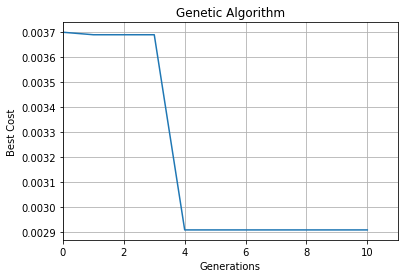

In [ ]:
# Parameters for building chromosomes
batch_size = [32, 64, 128]
learning_rate = [0.1, 0.01, 0.001]
optimizer = [1, 2, 3]

best_cost, best_solution = lstm_evaluation(population_size=20,
                                           gene_num=3,
                                           epoch=11,
                                           beta=1.0,
                                           mu=0.1,
                                           batch_size=batch_size,
                                           learning_rate=learning_rate,
                                           optimizer=optimizer)

plt.plot(best_cost)
plt.xlim(0, 11)
plt.xlabel('Generations')
plt.ylabel('Best Cost')
plt.title('Genetic Algorithm')
plt.grid(True)
plt.show()

#### Results Analysis

(1) Our purpose is to find a set of hyperparameters that can be used to train the LSTM model with the lowest loss value on the test set.

(2) As we can see from the diagram above, after training for 10 iterations, the loss value decreases to 0.0030, demonstrating the effectiveness of our genetic algorithm.

(3) The best batch size is 64, which is quite fitting for this dataset since it's not too small or large.

(4) The best learning rate is 0.1. This result is a bit surprising since 0.1 is a large value for the learning rate. We explain that our dataset is small and pre-processed. Therefore, the LSTM network can easily approximate the distribution of the data and find the optimal solution. When the dataset becomes larger and more diverse, a smaller learning rate would be better.

(5) The best optimizer is Adam. Adam optimized is insensitive to the learning rate. Therefore, it has been widely used in many deep learning models as a default optimizer.